In [1]:
#from pygraph.classes.graph import graph
#from pygraph.readwrite import dot
#from pygraph.algorithms.minmax import shortest_path
#from pygraph.algorithms.accessibility import connected_components
#from pygraph.algorithms.pagerank import pagerank

In [2]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [3]:
import itertools
import random
import statistics

In [49]:
from scipy.stats import power_divergence

In [ ]:
from sklearn.linear_model import LinearRegression

In [4]:
from network import *

In [5]:
import math

In [6]:
from loaders import *

In [7]:
from IPython.core.display import Image, display

In [8]:
def construct_graph_filtered(old_graph, node_predicate, egde_predicate):
    new_graph = nx.Graph()
    for node in old_graph.nodes():
        if node_predicate(node):
            new_graph.add_node(node)
    for edge in old_graph.edges():
        if node_predicate(edge[0]) and node_predicate(edge[1]) and egde_predicate(edge):
            new_graph.add_edge(edge)
    return new_graph

In [9]:
# calculate distance distribution for 
# detect small world phenomenon
def get_distance_stat(graph, n):
    stat = {}
    summ = len(graph.nodes()) * n
    for i in range(n): # iterative calculation of shortest path
        random_author = random.choice(graph.nodes())
        distances = nx.shortest_path_length(graph, random_author)
        for x in distances.values():
            stat[x] = stat.get(x, 0) + 1;
    return dict( (key, value / summ) for key, value in stat.items() )
        

In [10]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [11]:
import networkx as nx
#calculate centrality statistics
def get_centrality_stat(graph):
    N = 10
    centrality_stat = nx.degree_centrality(graph)
    print("----------")
    print("Average degree node centrality:", sum(centrality_stat.values())/len(centrality_stat) )
    
    max_centrality = max(centrality_stat.values())
    print("Maxumum degree node centrality:", max_centrality)
    
    nodes_num = len(graph.nodes())
    print("Degree graph centrality:", 
          sum([max_centrality - x for x in centrality_stat.values()])/((nodes_num - 1)*(nodes_num - 2)))
    
    print("----------")
    
    return dict((key, centrality_stat.get(key)) for key in take(N, centrality_stat) )
        

In [42]:
def calc_pagerank(graph):
    TOP = 50
    percent_threshold = 0.1
    weighted_nodes = nx.pagerank(graph)
    sorted_nodes = sorted(weighted_nodes.items(), key = lambda pair: pair[1], reverse=True)
    node_ranks = dict( (val, idx) for idx, val in enumerate(sorted_nodes))
    print(sorted_nodes[0:TOP])
    top_subgraph = graph.subgraph([x[0] for x in sorted_nodes[0:TOP]])
    return (top_subgraph, weighted_nodes, sorted_nodes)
    

In [13]:
def plot_dict(stat):
    plt.plot([x for x in stat.keys()], [x for x in stat.values()])
    plt.show()

In [34]:
def plot_weighet_graph(graph, weights=None):
    if weights == None:
        weights = [1] * len(graph.nodes())
    
    nodesize = [weights[v] * 10000 for v in graph]
    try:
        pos=nx.nx_agraph.graphviz_layout(graph)
    except:
        pos=nx.spring_layout(graph,iterations=20)
    nx.draw(graph, node_size=nodesize, pos=pos, node_color="w")
    nx.draw_networkx_labels(graph, pos)
    

In [46]:
coauthorNetwork = load_with_loader("./data/out_test.txt", parse_dataset_file, lambda article: 1995 < article.year < 2000)

Uniq authors: 1327


In [48]:
def get_time_seriece(weights_per_period, node):
    return [weights.get(node, 0.0) for weights in weights_per_period]

In [ ]:
def get_weights_in_period(file ,start, end):
    coauthorNetwork = load_with_loader(file, parse_dataset_file, lambda article: start <= article.year < end)
    (auth_subgraph, auth_weights, auth_sorted_nodes) = calc_pagerank(coauthorNetwork.gr)
    (cite_subgraph, cite_weights, cite_sorted_nodes) = calc_pagerank(coauthorNetwork.cgr)
    return ((auth_weights, auth_sorted_nodes), (cite_weights, cite_sorted_nodes) )

In [47]:
# Analyse time series

file = "./data/out_test.txt"

coauthorNetwork = load_with_loader(file, parse_dataset_file)
nodes_count = len(coauthorNetwork.gr.nodes())

train_authros = coauthorNetwork.gr.nodes()[:nodes_count // 2]
test_authors = coauthorNetwork.gr.nodes()[nodes_count // 2:]

weights_per_period = []
weights_per_period.append(get_weights_in_period(file, 1990, 1995))
weights_per_period.append(get_weights_in_period(file, 1995, 2000))
weights_per_period.append(get_weights_in_period(file, 2000, 2005))
weights_per_period.append(get_weights_in_period(file, 2005, 2010))

weights_per_period_auth = [ w[0][0] for x in weights_per_period ]
weights_per_period_cite = [ w[1][0] for x in weights_per_period ]

x_train = [get_time_seriece(weights_per_period_auth, author) 
           + get_time_seriece(weights_per_period_cite[0:-1], author) for author in test_authors]
y_train = [weights_per_period_cite[-1].get(author, 0.0) for author in test_authors ]

print(x_train[0:10])
print(y_train[0:10])

x_test = [get_time_seriece(weights_per_period_auth, author) 
           + get_time_seriece(weights_per_period_cite[0:-1], author) for author in test_authors]
y_test = [weights_per_period_cite[-1].get(author, 0.0) for author in test_authors ]

lm = LinearRegression(normalize=True)
lm.fit(x_train, y_train)

print(lm.predict(x_test)[0:10])
print(y_test[0:10])


[('Mark Guzdial', 0.0026592196203747798), ('E. R. Hancock', 0.0017962633306878556), ('N. Ahuja', 0.0017305387590768467), ('J. Kittler', 0.0017257339419949336), ('Y. Lecourtier', 0.001590098733871055), ('Gerhard Fischer', 0.001585525402123144), ('Don Tica', 0.001526093427411262), ('N. Yokoya', 0.001494938162414411), ('Thomas Eiter', 0.001494938162414411), ('Pere Garcia', 0.0014710935583763264), ('C. Y. Suen', 0.0014416857946968013), ('Peter Hagoort', 0.0014416857946968013), ('R. P. W. Duin', 0.0013669231474266442), ('D. Barba', 0.001366923147426644), ('N. Hagita', 0.001331317755351859), ('Rick Barba', 0.001331317755351859), ('J. Ghosh', 0.001331317755351859), ('Daniel C. Edelson', 0.001331317755351859), ('Y-S. Chen', 0.001331317755351859), ('S. Y. Yuen', 0.001331317755351859), ('S. Dellepiane', 0.001331317755351859), ('Philip J. Smith', 0.001331317755351859), ('S. Salem', 0.0013238006887107748), ('A. Rosenfeld', 0.0013238006887107748), ('David Chong', 0.0013238006887107748), ('Elliot So

In [63]:
def analize_component(coauthorNetwork, components, component_num):
    print("----------")
    print("Component:", component_num + 1)
    PRECISION = 50 # number of authors to calc avg distance

    component_sizes = dict( (idx, len(c)) for idx, c in enumerate(components) )

    the_component = components[component_num]

    component_subgraph = coauthorNetwork.gr.subgraph(the_component)
    
    print("Authors count:",len(component_subgraph.nodes()))
    stat = get_distance_stat(component_subgraph, PRECISION)
    
    print("Mean distance:", sum([value * key for key, value in stat.items()]))
    print(" ")
    print("Distance distribution")
    plot_dict(stat)
    
    cstat = get_centrality_stat(coauthorNetwork.cgr)
    print("Degree Nodes Centrality (first N elements):", cstat)
    #print(stat)



In [30]:
def load_with_loader(file, loader, article_filter = None):
    coauthorNetwork = CoauthorNetwork()
    if article_filter == None:
        article_filter = lambda x: True
    for article in loader(file):
        if article_filter(article):
            coauthorNetwork.add_article(article)

    print("Uniq authors:", len([x for x in coauthorNetwork.author_to_article.keys()]))
    return coauthorNetwork
    
#file = "./data/authors/Medical Informatics.txt"
#file = "./data/out_test.txt"
#coauthorNetwork = analyse(file, parse_dataset_file)
#components = connected_components(coauthorNetwork.gr)


#!dot 'graph.dot' -Tpng -o "graph.png"
#display(Image('graph.png' ))

In [61]:
def run_analyse(file, article_filter = None):
    print("Dataset:", file)
    coauthorNetwork = load_with_loader(file, parse_dataset_file, article_filter)
    
    components = [c for c in sorted(nx.connected_components(coauthorNetwork.gr), key=len, reverse=True)]
    
    components_sizes = dict((idx, math.log(float(len(c)))) for idx, c in enumerate(components))
    print(" ")
    print("Connected component distribution (log-scale)")
    plot_dict(components_sizes)
    
    print(power_divergence([len(c) for c in components]))
    
    #components = connected_components(coauthorNetwork.gr)
    component_count = len(components)
    print("Connected component count:", component_count)
    
    analize_component(coauthorNetwork, components, 0)

Dataset: ./data/out_test.txt
Uniq authors: 42619
 
Connected component distribution (log-scale)


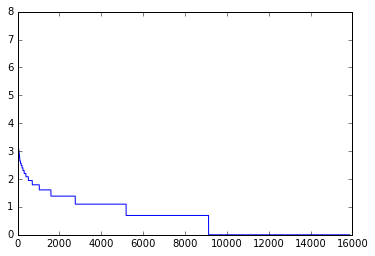

Power_divergenceResult(statistic=3128355.7077359874, pvalue=0.0)
Connected component count: 15871
----------
Component: 1
Authors count: 2870
Mean distance: 12.924613240418113
 
Distance distribution


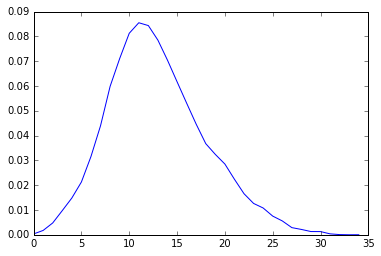

----------
Average degree node centrality: 2.314708766522422e-05
Maxumum degree node centrality: 0.001685690892452921
Degree graph centrality: 4.003814186637142e-08
----------
Degree Nodes Centrality (first N elements): {'438401': 2.4081298463613157e-05, '11449': 0.0, '14561': 0.0, '27154': 7.224389539083947e-05, '19618': 0.0, '456394': 2.4081298463613157e-05, '7128': 0.0, '576182': 2.4081298463613157e-05, '13454': 0.0, '10906': 0.0}


In [64]:
run_analyse("./data/out_test.txt")
#run_analyse("./data/authors/Database.txt")
#run_analyse("./data/authors/Data Mining.txt")
#run_analyse("./data/authors/Theory.txt")
#run_analyse("./data/authors/Visualization.txt")
